# Data Cleansing and Preprocess

### Collecting libraries for cleansing

In [1]:
import re
import pandas as pd
import numpy as np

# Pakai PySastrawi buat bantu stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Pakai nltk buat ambil stopwords nya
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load data and supporting files

In [2]:
# Main file, di-define sebagai df_data
colnames = ['text', 'sentiment']
df_data = pd.read_csv('train_preprocess.tsv', sep='\t', header=None, names=colnames)
print('Done')

Done


In [3]:
# Kamus alay
kamus_label = ['alay', 'tidak alay']
kamus_alay = pd.read_csv('new_kamusalay.csv', header=None, encoding='latin-1', names=kamus_label)
print('Done')

Done


In [4]:
df_data.head()

,text,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [5]:
# Cek ada null atau nggak
df_data.isnull().sum()

text         0
sentiment    0
dtype: int64

In [6]:
# Iseng aja liat data seperti apa kalau didescribe
df_data.describe()

,text,sentiment
count,11000,11000
unique,10933,3
top,kesal,positive
freq,4,6416


In [7]:
# Mastiin lagi aja gak ada null
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       11000 non-null  object
 1   sentiment  11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


Stopwords

In [8]:
# Iseng aja liat list stopwordnya
list_stopword = stopwords.words('indonesian')
print(list_stopword[0:10])
print(len(list_stopword))

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir']
758


In [9]:
# Extend stopword biar makin banyak, siapatau kurang
list_stopword.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', 'nya', 'ber', 'banget', 'kali'])
list_stopword
print(len(list_stopword))

801


In [10]:
# Buat hilangin duplicated data di dalam list
list_stopword = list(dict.fromkeys(list_stopword))
print(len(list_stopword))

798


In [11]:
# List nya kita ubah jadi set
list_stopword = set(list_stopword)
list_stopword

{'&amp',
 'ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'aja',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'amp',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banget',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'ber',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'b

In [12]:
# Ini dibuat soalnya sebelumnya data-data ini masuk ke dalam stopword nltk indonesian
bukan_stopword = {'baik', 'masalah', 'yakin', 'tidak', 'pantas', 'lebih'}

In [13]:
final_stopword = set([word for word in list_stopword if word not in bukan_stopword])
len(final_stopword)

792

In [14]:
# Iseng aja liat isi kamus alay
kamus_alay.head()

,alay,tidak alay
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


#### Data Cleansing :
- Normalizing words
- Stemming
- Removing Stopwords
- Final cleaning using RegEx

In [15]:
# Normalisasi kata alay (kalau ada), pake kamus alay
kamus_alay_map = dict(zip(kamus_alay['alay'], kamus_alay['tidak alay']))

# Bikin fungsi normalisasinya
def normalisasi_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

In [16]:
# Stemming pake PySastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Bikin fungsi stemming nya
def stemming(text):
    text = stemmer.stem(text)
    return text

In [17]:
# Bikin fungsi hilangin stopword
def remove_stopword(text):
    text = ' '.join(['' if word in final_stopword else word for word in text.split(' ')])
    text = text.strip()
    return text

In [18]:
# Bikin fungsi hilangin url pattern, whitespace berlebih, newline, tab, dan simbol-simbol
def cleaning(text):

    # Regex patern buat ilangin url nya di assign ke variabel url_pattern
    url_pattern = r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*'

    # Hilangin url_pattern pakai re.sub
    text = re.sub(url_pattern, " ", text)

    # Hilangin selain a-zA-Z0-9
    text = re.sub(r'[^a-zA-Z0-9]', " ", text)

    # Pisahin teks dan digit yang nyambung dalam satu string
    text = re.sub(r'(\d+)', r' \1 ', text)

    # Hilangin spasi 2x atau lebih
    text = re.sub(r' {2,}', " ", text)

    # Hilangin whitespace sama newline
    text = re.sub(r'\n\t',' ',text)

    # Hilangin kata 'user'
    text = re.sub(r'user',' ',text)

    # Hilangin angka
    text = re.sub(r'(\d+)'," ", text)

    # Ubah string jadi lowercase
    text = text.lower()
    return text

In [19]:
# Pakai fungsi normalisasi alay untuk seluruh data dalam df_data
for data in [df_data]:
    data['text_normalized'] = data['text'].apply(normalisasi_alay)
print('Done')

Done


In [20]:
idx = 787
print(df_data['text'][idx])
print(df_data['text_normalized'][idx])

kebaikan
kebaikan


In [21]:
# Pakai fungsi stemming untuk seluruh data dalam df_data
for data in [df_data]:
    data['text_stem'] = data['text_normalized'].apply(stemming)
print('Done')

Done


In [22]:
print(df_data['text_normalized'][idx])
print(df_data['text_stem'][idx])

kebaikan
baik


In [23]:
# Pakai fungsi hilangin stopword untuk seluruh data dalam df_data
for data in [df_data]:
    data['text_wsw'] = data['text_stem'].apply(remove_stopword)
print('Done')

Done


In [24]:
print(df_data['text_stem'][idx])
print(df_data['text_wsw'][idx])

baik
baik


In [25]:
# Pakai fungsi cleaning untuk seluruh data dalam df_data
for data in [df_data]:
    data['text_clean'] = data['text_wsw'].apply(cleaning)
print('Done')

Done


In [26]:
print(df_data['text_wsw'][idx])
print(df_data['text_clean'][idx])

baik
baik


In [27]:
# Mengurutkan kolom biar enak dilihat
df_data = df_data[['text', 'text_normalized', 'text_stem', 'text_wsw', 'text_clean', 'sentiment']]
df_data.head()

,text,text_normalized,text_stem,text_wsw,text_clean,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini milik oleh usaha pabrik tahu yang s...,warung milik usaha pabrik puluh kenal ...,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus k212 mmbri hujjah partai ...,mohon ulama lurus k mmbri hujjah partai diwl...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung . te...,lokasi strategis di jalan sumatra bandung temp...,lokasi strategis jalan sumatra bandung nyam...,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia unboxing paket barang bag...,betapa bahagia unboxing paket barang bagus beli,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh . jadi mahasiswa jangan sombong dong . ka...,aduh jadi mahasiswa jangan sombong dong kasih ...,aduh mahasiswa sombong kasih kartu kuning ...,aduh mahasiswa sombong kasih kartu kuning ajar...,negative


In [28]:
# Compare text awal banget vs yang sudah lewatin semua tahap cleansing
print(df_data['text'][idx])
print(df_data['text_clean'][idx])

kebaikan
baik


### Save new csv file for clean text

In [29]:
# Drop dulu kolom yang udah gak kepake biar gak kebanyakan
df_data = df_data.drop(['text_normalized', 'text_stem', 'text_wsw'], axis=1)

In [30]:
# Iseng cek dataframe baru nya
df_data.head()

,text,text_clean,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus k mmbri hujjah partai diwl...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia unboxing paket barang bagus beli,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh mahasiswa sombong kasih kartu kuning ajar...,negative


In [31]:
print(df_data['text_clean'][787])

baik


In [32]:
# Save dataframe nya ke csv lagi
df_data.to_csv('text_clean.csv', index=False)

### Preprocess selesai di sini

# Data Preparation For Modeling

### Collecting libraries

In [33]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Dropout, GlobalAveragePooling1D

### Data Overview

In [34]:
df_data = pd.read_csv('text_clean.csv')

In [35]:
df_data.head()

,text,text_clean,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus k mmbri hujjah partai diwl...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia unboxing paket barang bagus beli,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh mahasiswa sombong kasih kartu kuning ajar...,negative


In [36]:
idx = 787
print('Teks Awal :',df_data['text'][idx])
print('Teks Preprocessed :',df_data['text_clean'][idx])

Teks Awal : kebaikan
Teks Preprocessed : baik


In [37]:
df_data[df_data['text_clean'].isnull()]

,text,text_clean,sentiment


In [38]:
print(len(df_data['sentiment']))

11000


## Data Tokenization

#### Assign X

In [39]:
X = df_data['text_clean'].astype(str)
max_features = 100000

# Tokenisasi
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
sequence_len = [len(seq) for seq in df_data['text_clean'].str.split()]
max_len= max(sequence_len)

# Padding
X = pad_sequences(X, maxlen=max_len)

# Menampilkan bentuk akhir dari data
X.shape

(11000, 55)

In [40]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer berhasil disimpan!")

Tokenizer berhasil disimpan!


In [41]:
import pickle

with open('text_preprocessing.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('text_preprocessing.pickle has created!')

text_preprocessing.pickle has created!


#### Mapping dan assign y

In [42]:
# Dilakukan proses mapping karna label y > 2
sentiment_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = df_data['sentiment'].map(sentiment_encode).values
print(y)
print(y.shape)

[2 1 2 ... 1 0 2]
(11000,)


#### OneHot Encode

In [43]:
onehot = OneHotEncoder()
onehot.fit(y.reshape(-1,1))
# y_hot = onehot.transform(y.reshape(-1,1))
y_hot = onehot.transform(y.reshape(-1,1)).toarray()
print(y_hot.shape)

(11000, 3)


In [44]:
y_hot[0:10]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [45]:
import pickle

with open('y_label.pickle', 'wb') as handle:
    pickle.dump(y_hot, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_label.pickle has created!')

y_label.pickle has created!


### Data Split

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y_hot, test_size=0.20, random_state=123)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(8800, 55) (8800, 3)
(2200, 55) (2200, 3)


# Modeling

In [47]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras import models
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Dropout, GlobalAveragePooling1D

### Keras NN

In [48]:
embed_dim = 128
model_nn = tf.keras.models.Sequential([

    # Pakai layer embedding, isinya max_features, output_dim, dan input_shape
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embed_dim, input_shape=(max_len,)),
    tf.keras.layers.Flatten(),
    #Layer Dense
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Assign loss function yang mau dipakai ke dalam variabel loss_fn
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Assign optimizer yang mau dipakai ke dalam variabel (sgd karena pakai optimizer SGD), learning rate bisa ditunning untuk cari hasil yg lebih bagus
sgd = tf.keras.optimizers.SGD(learning_rate=0.005)

# Bikin kondisi untuk early stopping berdasarkan parameter yang dimonitor
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='min',
    verbose=1,
    patience=90,
    restore_best_weights=True)

# Compile model
model_nn.compile(loss=loss_fn, optimizer=sgd, metrics=['accuracy'])

# Menampilkan summary dari model_nn yang udah dibuah
model_nn.summary()

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 55, 128)        │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7040)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       450,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,250,819 (50.55 MB)

 Trainable params: 13,250,819 (50.55 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Assign nilai epoch ke dalam n_epoch, gak diassign pun gak apa apa, langsung masuk di model fit
n_epochs = 100

# Simpan hasil model fit nya ke dalam history, supaya bisa pakai hasil training yang paling bagus setelah proses training
history_nn = model_nn.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_val, y_val), callbacks=[es], batch_size=64)

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5732 - loss: 1.0297 - val_accuracy: 0.5814 - val_loss: 0.9219
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5845 - loss: 0.9184 - val_accuracy: 0.5814 - val_loss: 0.8758
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5911 - loss: 0.8757 - val_accuracy: 0.5845 - val_loss: 0.8425
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6141 - loss: 0.8526 - val_accuracy: 0.6632 - val_loss: 0.8177
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6532 - loss: 0.8168 - val_accuracy: 0.6773 - val_loss: 0.8033
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6511 - loss: 0.8180 - val_accuracy: 0.6782 - val_loss: 0.7942
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6536 - loss: 0.8022 - val_accuracy: 0.6795 - val_loss: 0.7905
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6448 - loss: 0.8127 - 

In [50]:
# Panggil history dari model fitting tadi pakai fungsi history
result_nn = history_nn.history

# Define num_epochs buat keperluan visualisasi
num_epochs = np.arange(0, len(result_nn['accuracy']))

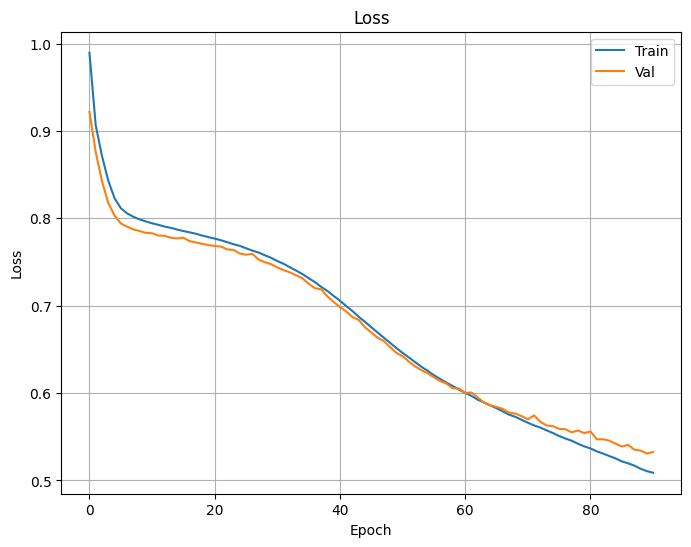

In [51]:
# Visualisasi hasil training dan evaluasinya
plt.figure(figsize=(8,6))
plt.title('Loss')
plt.plot(num_epochs, result_nn['loss'])
plt.plot(num_epochs, result_nn['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

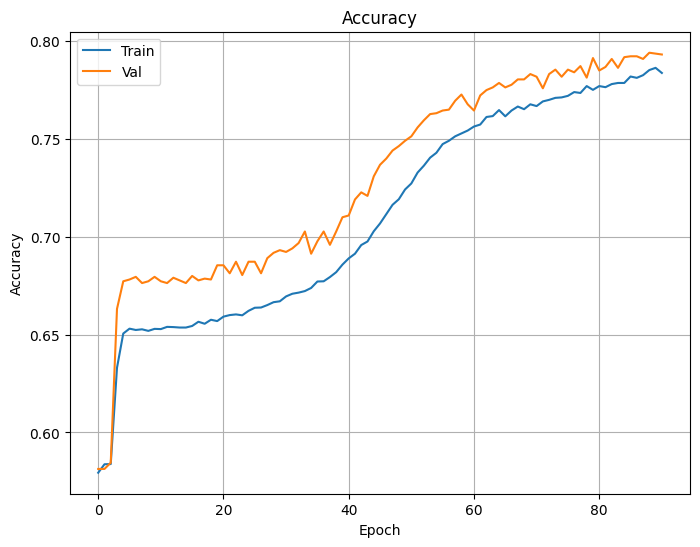

In [52]:
# Visualisasi hasil training dan evaluasinya
plt.figure(figsize=(8,6))
plt.title('Accuracy')
plt.plot(num_epochs, result_nn['accuracy'])
plt.plot(num_epochs, result_nn['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

Evaluasi model

In [53]:
y_pred = model_nn.predict(X_val)

y_pred_classes = y_pred.argmax(axis=1)
y_val_classes = y_val.argmax(axis=1)
print("Testing selesai")
print(classification_report(y_val_classes, y_pred_classes, zero_division=0.0))

accuracy = accuracy_score(y_val_classes, y_pred_classes)
print('Accuracy Score SGD (0.005) :', round(accuracy, 2))

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       708
           1       0.00      0.00      0.00       213
           2       0.58      1.00      0.74      1279

    accuracy                           0.58      2200
   macro avg       0.19      0.33      0.25      2200
weighted avg       0.34      0.58      0.43      2200

Accuracy Score SGD (0.005) : 0.58


In [54]:
# # Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
# import numpy as np
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5,random_state=1,shuffle=True)

# accuracies = []

# label = y_hot

# for iteration, data in enumerate(kf.split(X), start=1):

#     data_train   = X[data[0]]
#     target_train = label[data[0]]

#     data_test    = X[data[1]]
#     target_test  = label[data[1]]


#     model_nn.compile(
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
#     loss='CategoricalCrossentropy',
#     metrics=['accuracy'])

#     history_nn = model_nn.fit(
#     data_train,
#     target_train,
#     epochs = 100,
#     validation_data = (data_test, target_test),
#     callbacks=[es],
#     batch_size=64,
#     verbose=1,
#     )

#     predictions = model_nn.predict(X_val)
#     y_pred = predictions

#     # for the current fold only
#     accuracy = accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))

#     print("Training ke-", iteration)
#     print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))
#     print("======================================================")

#     accuracies.append(accuracy)

# # this is the average accuracy over all folds
# average_accuracy = np.mean(accuracies)

# print()
# print()
# print()
# print("Rata-rata Accuracy: ", round(average_accuracy,2))

Save Model

In [62]:
model_nn.save('nn_model.keras')
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [73]:
from keras.models import load_model
# Memuat model
model_nn = load_model('nn_model.keras')

# Memuat tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
def cleansing(text):
    text = re.sub(r'\\t|\\n|\\u', ' ', text) #Menghapus karakter khusus seperti tab, baris baru, karakter Unicode, dan backslash.
    text = re.sub(r"https?:[^\s]+", ' ', text)  # Menghapus http / https
    text = re.sub(r'(\b\w+)-\1\b', r'\1', text)
    text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)  # Menghapus karakter yang dimulai dengan '\x' diikuti oleh dua karakter huruf atau angka
    # text = re.sub(r'(\d+)', r' \1 ', text)  # Memisahkan angka dari teks
    text = re.sub(r'[^a-zA-Z]+', ' ', text)  # Menghapus karakter kecuali huruf, dan spasi
    text = re.sub(r'\brt\b|\buser\b', ' ', text) # Menghapus kata-kata 'rt' dan 'user'
    text = text.lower()
    tokens = nltk.word_tokenize(text)  # Tokenisasi
    tokens = [word for word in tokens if word not in final_stopword]  # Menghapus stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    text = ' '.join(tokens)  # Menggabungkan kembali teks
    return text

class_labels = ['negatif', 'netral', 'positif']

original_text = 'babi lo prab*w* anjing gua sumpahin kamu mati saja . dasar sampah masyarakat .1234'
cleaned_text = cleansing(original_text)
print("Original text:", original_text)
print("Cleaned text:", cleaned_text)

text_sequence = tokenizer.texts_to_sequences([cleaned_text])
text_padded = pad_sequences(text_sequence, maxlen=55)

result = model_nn.predict(text_padded)[0]
predicted_class = np.argmax(result)
predicted_label = class_labels[predicted_class]

print('Sentiment :')
print(predicted_label)

Original text: babi lo prab*w* anjing gua sumpahin kamu mati saja . dasar sampah masyarakat .1234
Cleaned text: babi lo prab w anjing gua sumpahin mati dasar sampah masyarakat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Sentiment :
positif


### LSTM

In [64]:
epoch_lstm = 100
embed_dim_lstm = 25
# max_features = 100000

# Model LSTM
model_lstm = tf.keras.models.Sequential([ # inisialisasi model
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embed_dim_lstm, input_length=X.shape[1]), # memetakan text ke dalam vektor
    # tf.keras.layers.LSTM(128, return_sequences=True), # hidden layer 1
    tf.keras.layers.LSTM(64, activation='tanh'), # hidden layer 2
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(3, activation='softmax') # layer output
])

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False) # mendefinisikan loss function

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Memantau val_loss pada data validasi
    mode='min', # Proses pelatihan akan berhenti ketika val_loss tidak berkurang
    verbose=1, # Menampilkan pesan ketika Early Stopping diaktifkan
    patience=15, # Pelatihan akan berhenti jika val_loss tidak membaik setelah 50 epoch
    restore_best_weights=True
)

# adam = tf.optimizers.Adam(learning_rate=0.0001) # Defini optimizer Adam (Adaptive Moment Estimation)
sgd = tf.keras.optimizers.SGD(learning_rate=0.075) # Defini optimizer SGD (Stochastic Gradient Descent)

model_lstm.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=['accuracy'])


model_lstm.summary() # summary model

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [65]:
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    epochs = epoch_lstm,
    validation_data = (X_val, y_val),
    callbacks=[es],
    batch_size=64,
    verbose=1,
    )

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5744 - loss: 1.0245 - val_accuracy: 0.5814 - val_loss: 0.9279
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5883 - loss: 0.9207 - val_accuracy: 0.5814 - val_loss: 0.9105
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5845 - loss: 0.9163 - val_accuracy: 0.5814 - val_loss: 0.9049
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5794 - loss: 0.9206 - val_accuracy: 0.5814 - val_loss: 0.9012
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5871 - loss: 0.9099 - val_accuracy: 0.5814 - val_loss: 0.8961
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5804 - loss: 0.9142 - val_accuracy: 0.5814 - val_loss: 0.8866
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5771 - loss: 0.8995 - val_accuracy: 0.5814 - val_loss: 0.8601
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5906 - loss: 0.8628 - 

In [66]:
result_lstm = history_lstm.history
n_epochs_lstm = np.arange(0, len(result_lstm['accuracy']))

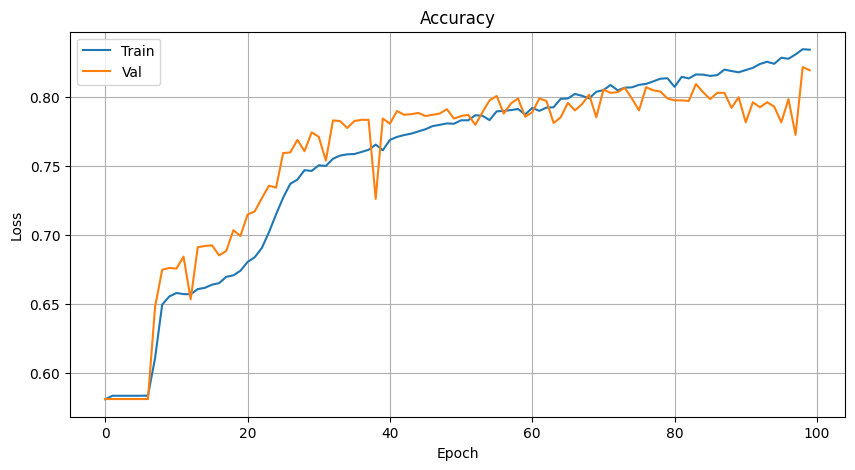

In [67]:
plt.figure(figsize=(10,5))
plt.title('Accuracy')
plt.plot(n_epochs_lstm, result_lstm['accuracy'])
plt.plot(n_epochs_lstm, result_lstm['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

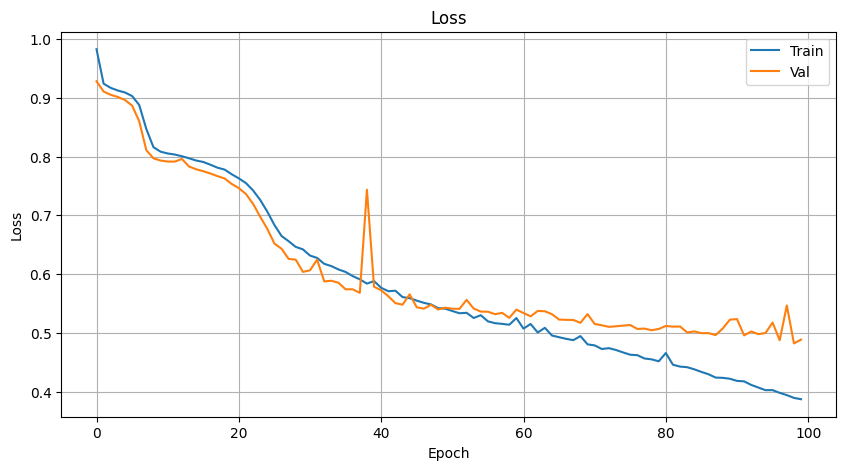

In [68]:
plt.figure(figsize=(10,5))
plt.title('Loss')
plt.plot(n_epochs_lstm, result_lstm['loss'])
plt.plot(n_epochs_lstm, result_lstm['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

In [69]:
y_pred_lstm = model_lstm.predict(X_val)

y_pred_classes_lstm = y_pred_lstm.argmax(axis=1)
y_val_classes_lstm = y_val.argmax(axis=1)
print("Testing selesai")
print(classification_report(y_val_classes_lstm, y_pred_classes_lstm, zero_division=0.0))

accuracy = accuracy_score(y_val_classes_lstm, y_pred_classes_lstm)
print('Accuracy Score SDG (0.075) :', round(accuracy, 2))

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       708
           1       0.63      0.15      0.25       213
           2       0.90      0.91      0.91      1279

    accuracy                           0.82      2200
   macro avg       0.75      0.64      0.64      2200
weighted avg       0.82      0.82      0.80      2200

Accuracy Score SDG (0.075) : 0.82


In [70]:
model_lstm.save('lstm_model.keras')
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [72]:
from keras.models import load_model
# Memuat model
model_lstm = load_model('nn_model.keras')

# Memuat tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
def cleansing(text):
    text = re.sub(r'\\t|\\n|\\u', ' ', text) #Menghapus karakter khusus seperti tab, baris baru, karakter Unicode, dan backslash.
    text = re.sub(r"https?:[^\s]+", ' ', text)  # Menghapus http / https
    text = re.sub(r'(\b\w+)-\1\b', r'\1', text)
    text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)  # Menghapus karakter yang dimulai dengan '\x' diikuti oleh dua karakter huruf atau angka
    # text = re.sub(r'(\d+)', r' \1 ', text)  # Memisahkan angka dari teks
    text = re.sub(r'[^a-zA-Z]+', ' ', text)  # Menghapus karakter kecuali huruf, dan spasi
    text = re.sub(r'\brt\b|\buser\b', ' ', text) # Menghapus kata-kata 'rt' dan 'user'
    text = text.lower()
    tokens = nltk.word_tokenize(text)  # Tokenisasi
    tokens = [word for word in tokens if word not in final_stopword]  # Menghapus stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    text = ' '.join(tokens)  # Menggabungkan kembali teks
    return text

class_labels = ['negatif', 'netral', 'positif']
original_text_lstm = 'anak sekarang sulit untuk dinasehati'
cleaned_text_lstm = cleansing(original_text_lstm)
text_sequence_lstm = tokenizer.texts_to_sequences([cleaned_text_lstm])
text_padded_lstm = pad_sequences(text_sequence_lstm, maxlen=max_len)

result_lstm = model_lstm.predict(text_padded_lstm)[0]
predicted_class_lstm = np.argmax(result_lstm)
predicted_label_lstm = class_labels[predicted_class_lstm]

print('Sentiment :')
print(predicted_label_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Sentiment :
positif
